# **Automated Machine Learning (AutoML) Task: Classification and Model Calibration**

## **Introduction**

The goal of this project is to develop a robust classification model for an AutoML task. However, even with a well-performing model, there can be a significant mismatch between predicted probabilities and the actual likelihood of events. This is where **model calibration** plays a crucial role, ensuring that the predicted probabilities align better with real-world outcomes.

This notebook outlines the development process, starting from data exploration to the final step of model calibration, highlighting the key stages involved in building a reliable and well-calibrated classification model.

---

## **Development Stages**

### 1. **Data Exploration**

### 2. **Data Preprocessing**


### 3. **Model Selection**


### 4. **Model Fine-tuning**


### 5. **Model Calibration**


### 6. **Conclusion**


In [79]:

import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA



## Data Exploration 

In [80]:
# Load data
df = pd.read_csv('/kaggle/input/knowledge-base/Knowledge_base_train.csv')
df.head()

,class,num_clients,Sum of Instances in Clients,Max. Of Instances in Clients,Min. Of Instances in Clients,Stddev of Instances in Clients,Average Dataset Missing Values %,Min Dataset Missing Values %,Max Dataset Missing Values %,Stddev Dataset Missing Values %,...,Min No. Of Insignificant Lags in Target,Stddev No. Of Insignificant Lags in Target,Avg. No. Of Seasonality Components in Target,Max No. Of Seasonality Components in Target,Min No. Of Seasonality Components in Target,Stddev No. Of Seasonality Components in Target,Average Fractal Dimensionality Across Clients of Target,Maximum Period of Seasonality Components in Target Across Clients,Minimum Period of Seasonality Components in Target Across Clients,Entropy of Target Stationarity
0,XGBRegressor,10,13821,1383,1382,0.300000,4.992466,4.121475,5.571635,0.448970,...,0,0,2,2,2,0,0.009829,13,2,0.325083
1,XGBRegressor,5,4031,807,806,0.400000,4.762946,3.970223,6.203474,0.875041,...,0,0,0,0,0,0,0.033774,0,0,0.673012
2,HUBERREGRESSOR,5,17280,3456,3456,0.000000,5.104167,4.745370,5.295139,0.188945,...,2,0,0,0,0,0,0.017802,0,0,0.673012
3,LinearSVR,5,6911,1383,1382,0.400000,4.934113,4.052098,5.571635,0.524086,...,1,0,0,0,0,0,0.390252,0,0,0.000000
4,XGBRegressor,15,24181,1613,1612,0.249444,4.966717,3.535980,6.389578,0.693981,...,0,0,1,1,1,0,0.014879,4,4,0.392674


In [81]:
df.dtypes

class                                                                 object
num_clients                                                            int64
Sum of Instances in Clients                                            int64
Max. Of Instances in Clients                                           int64
Min. Of Instances in Clients                                           int64
Stddev of Instances in Clients                                       float64
Average Dataset Missing Values %                                     float64
Min Dataset Missing Values %                                         float64
Max Dataset Missing Values %                                         float64
Stddev Dataset Missing Values %                                      float64
Average Target Missing Values %                                      float64
Min Target Missing Values %                                          float64
Max Target Missing Values %                                          float64

In [82]:
df["class"].value_counts()

class
XGBRegressor         177
HUBERREGRESSOR        85
LinearSVR             69
LASSO                 46
QUANTILEREGRESSOR     17
ELASTICNETCV           6
Name: count, dtype: int64

- The data is imbalanced that is why we will split it in stratified way to make sure that train and test distributions monitor and mimic the original dataset distribution and this improves the model performance 

In [83]:
df.shape

(400, 58)

In [84]:
df.isnull().sum().sum()

0

## Data Preprocessing 

In [85]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
# Split features and target
X = df.drop(columns=['class'])  # Replace 'Best_Model' with your target column
y = df['class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
import optuna

# Set Optuna's logging level to WARN to suppress INFO messages
optuna.logging.set_verbosity(optuna.logging.WARNING)


##  **Model Selection**

In this task, we employed **Bayesian Optimization** instead of traditional hyperparameter tuning methods like Grid Search or Random Search. Bayesian Optimization is a powerful approach that builds a probabilistic model of the objective function and uses it to select the most promising hyperparameter combinations. This method is more efficient, as it focuses on exploring the hyperparameter space strategically, leading to faster convergence towards optimal values with fewer evaluations.

We conducted two main experiments during model selection:
1. **Without Dimensionality Reduction**: The model was trained on the full set of features without applying any dimensionality reduction techniques.
2. **With Dimensionality Reduction**: We used **Principal Component Analysis (PCA)** to reduce the dimensionality of the feature space, aiming to capture the most significant components and potentially improve model performance.

For each experiment, multiple runs were conducted to ensure the stability and reliability of the results. This iterative process allowed us to fine-tune the model and select the best hyperparameters.

### **Evaluation Metrics**

To assess the performance of our models, we utilized the following evaluation metrics:
- **Accuracy**: Measures the proportion of correct predictions out of the total predictions.
- **Precision**: Evaluates the accuracy of positive predictions.
- **Recall**: Measures the model’s ability to correctly identify positive instances.
- **F1 Score**: A harmonic mean of Precision and Recall, providing a balance between the two metrics.
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between predicted and actual values, providing insight into prediction errors.

Among these metrics, the **F1 Score** was chosen as the primary metric for model comparison. It offers a comprehensive evaluation of the model's performance by considering both correct and false predictions, making it particularly suitable for imbalanced datasets or cases where both precision and recall are equally important.


In [87]:
def objective_no_feature_selection(trial):
    # Suggest the model type
    model_type = trial.suggest_categorical('model', ['RandomForest', 'SVM', 'LogisticRegression', 'XGBoost'])
    
    # Define the model with expanded hyperparameter ranges
    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)  # Wider range, step added for efficiency
        max_depth = trial.suggest_int('max_depth', 5, 100)  # Increased max depth
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
    
    elif model_type == 'SVM':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True) 
        gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)  
        kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']) 
        model = SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=42)
    
    elif model_type == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-4, 1e3, log=True)  # Wider range
        solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'saga']) 
        model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
    
    else:  # XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)  # Wider range
        max_depth = trial.suggest_int('max_depth', 3, 30)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
    
    # Directly use the model without feature selection
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('mse', mse)
    
    return f1


In [88]:
import optuna
from tqdm import tqdm

def optimize_models(objective_function, n_trials=1000):
    """
    Optimize a given objective function using Optuna with progress bar and display the best results for each model type.

    Parameters:
    - objective_function: The function to optimize.
    - n_trials: Number of trials for optimization (default: 1000).

    Returns:
    - best_models: Dictionary containing the best metrics and hyperparameters for each model type.
    """
    # Initialize Optuna study
    study = optuna.create_study(direction='maximize')

    # Progress bar for optimization
    with tqdm(total=n_trials, desc="Optimizing Trials", unit="trial") as pbar:
        def tqdm_callback(study, trial):
            pbar.update(1)

        study.optimize(objective_function, n_trials=n_trials, callbacks=[tqdm_callback])
    
    # Initialize a dictionary to store the best trial for each model type
    best_models = {}

    # Iterate through all trials
    for trial in study.trials:
        model_type = trial.params['model']
        f1_score_trial = trial.user_attrs['f1']
        
        # Update the best model for each type based on F1 score
        if model_type not in best_models or f1_score_trial > best_models[model_type]['f1']:
            best_models[model_type] = {
                'trial': trial.number,
                'f1': f1_score_trial,
                'accuracy': trial.user_attrs['accuracy'],
                'precision': trial.user_attrs['precision'],
                'recall': trial.user_attrs['recall'],
                'mse': trial.user_attrs['mse'],
                'params': trial.params
            }

    # Print the best results for each model type
    for model_type, best in best_models.items():
        print(f"Best stats for {model_type}:")
        print(f"  Trial Number: {best['trial']}")
        print(f"  F1 Score: {best['f1']:.4f}")
        print(f"  Accuracy: {best['accuracy']:.4f}")
        print(f"  Precision: {best['precision']:.4f}")
        print(f"  Recall: {best['recall']:.4f}")
        print(f"  MSE: {best['mse']:.4f}")
        print(f"  Best Hyperparameters: {best['params']}")
        print()
    
    # Return the best models for further use
    return best_models


In [89]:
import time
start_time = time.time()
optimize_models(objective_no_feature_selection)
print((time.time() - start_time)/60)

Optimizing Trials:   1%|          | 11/1000 [00:03<06:05,  2.70trial/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Optimizing Trials:  26%|██▌       | 261/1000 [03:40<43:11,  3.51s/trial]  /opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Optimizing Trials:  36%|███▌      | 358/1000 [05:10<02:33,  4.18trial/s]  /opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

Best stats for SVM:
  Trial Number: 112
  F1 Score: 0.6722
  Accuracy: 0.6875
  Precision: 0.6884
  Recall: 0.6875
  MSE: 1.6750
  Best Hyperparameters: {'model': 'SVM', 'C': 693.9389103652735, 'gamma': 0.00033129904597730634, 'kernel': 'rbf'}

Best stats for LogisticRegression:
  Trial Number: 1
  F1 Score: 0.5907
  Accuracy: 0.6000
  Precision: 0.6041
  Recall: 0.6000
  MSE: 1.8125
  Best Hyperparameters: {'model': 'LogisticRegression', 'C': 12.93452986910484, 'solver': 'lbfgs'}

Best stats for RandomForest:
  Trial Number: 293
  F1 Score: 0.5489
  Accuracy: 0.5875
  Precision: 0.5945
  Recall: 0.5875
  MSE: 2.6000
  Best Hyperparameters: {'model': 'RandomForest', 'n_estimators': 500, 'max_depth': 85, 'min_samples_split': 13, 'min_samples_leaf': 2}

Best stats for XGBoost:
  Trial Number: 76
  F1 Score: 0.5687
  Accuracy: 0.5875
  Precision: 0.5900
  Recall: 0.5875
  MSE: 2.1000
  Best Hyperparameters: {'model': 'XGBoost', 'n_estimators': 450, 'max_depth': 21, 'learning_rate': 0.0492

In [90]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

def objective_pca(trial):
    model_type = trial.suggest_categorical('model', ['RandomForest', 'SVM', 'LogisticRegression', 'XGBoost'])
    num_components = trial.suggest_int('num_components', 5, min(X_train.shape[1], X_train.shape[0]))

    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
        max_depth = trial.suggest_int('max_depth', 5, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
    elif model_type == 'SVM':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)
        kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
        model = SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=42)
        
    elif model_type == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-4, 1e3, log=True)
        solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'saga'])
        model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
    else:
        n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
        max_depth = trial.suggest_int('max_depth', 3, 30)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.1)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1)
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    # PCA Selector
    feature_selector = PCA(n_components=num_components)

    pipeline = Pipeline([
        ('feature_reduction', feature_selector),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)

    # Store metrics and number of components
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('mse', mse)
    trial.set_user_attr('num_components', num_components)  # Store number of PCA components

    return f1


In [91]:
import optuna
from tqdm import tqdm

def optimize_models(objective_function, n_trials=1000):
    study = optuna.create_study(direction='maximize')

    # Adding TQDM progress bar for trial progress
    with tqdm(total=n_trials, desc="Optimizing Trials", unit="trial") as pbar:
        def tqdm_callback(study, trial):
            pbar.update(1)
        
        study.optimize(objective_function, n_trials=n_trials, callbacks=[tqdm_callback])
    
    best_models = {}

    for trial in study.trials:
        model_type = trial.params['model']
        f1_score_trial = trial.user_attrs['f1']
        
        if model_type not in best_models or f1_score_trial > best_models[model_type]['f1']:
            best_models[model_type] = {
                'trial': trial.number,
                'f1': f1_score_trial,
                'accuracy': trial.user_attrs['accuracy'],
                'precision': trial.user_attrs['precision'],
                'recall': trial.user_attrs['recall'],
                'mse': trial.user_attrs['mse'],
                'params': trial.params,
                'num_components': trial.user_attrs['num_components'],  # PCA components
            }

    for model_type, best in best_models.items():
        print(f"Best stats for {model_type}:")
        print(f"  Trial Number: {best['trial']}")
        print(f"  F1 Score: {best['f1']:.4f}")
        print(f"  Accuracy: {best['accuracy']:.4f}")
        print(f"  Precision: {best['precision']:.4f}")
        print(f"  Recall: {best['recall']:.4f}")
        print(f"  MSE: {best['mse']:.4f}")
        print(f"  Best Hyperparameters: {best['params']}")
        print(f"  Number of PCA Components: {best['num_components']}")
        print()
    
    return best_models


In [92]:
import time
start_time = time.time()
optimize_models(objective_pca)
print((time.time() - start_time)/60)

Optimizing Trials:   0%|          | 2/1000 [00:02<19:27,  1.17s/trial]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Optimizing Trials:   0%|          | 3/1000 [00:02<12:53,  1.29trial/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Optimizing Trials:   3%|▎         | 30/1000 [00:17<07:17,  2.22trial/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Best stats for XGBoost:
  Trial Number: 546
  F1 Score: 0.6591
  Accuracy: 0.6750
  Precision: 0.6937
  Recall: 0.6750
  MSE: 1.6500
  Best Hyperparameters: {'model': 'XGBoost', 'num_components': 35, 'n_estimators': 350, 'max_depth': 25, 'learning_rate': 0.08037386163464737, 'subsample': 0.6, 'colsample_bytree': 0.6}
  Number of PCA Components: 35

Best stats for LogisticRegression:
  Trial Number: 32
  F1 Score: 0.5950
  Accuracy: 0.6125
  Precision: 0.6219
  Recall: 0.6125
  MSE: 1.9000
  Best Hyperparameters: {'model': 'LogisticRegression', 'num_components': 47, 'C': 5.509289610093626, 'solver': 'liblinear'}
  Number of PCA Components: 47

Best stats for SVM:
  Trial Number: 802
  F1 Score: 0.5918
  Accuracy: 0.6125
  Precision: 0.6282
  Recall: 0.6125
  MSE: 1.9500
  Best Hyperparameters: {'model': 'SVM', 'num_components': 36, 'C': 1.0740154782742124, 'gamma': 0.012667873110690902, 'kernel': 'linear'}
  Number of PCA Components: 36

Best stats for RandomForest:
  Trial Number: 683


### **Comparison of Results: With and Without PCA**

To determine the impact of dimensionality reduction, we conducted multiple experiments with and without applying PCA. Below is a comparison of the best results for each model:

| Model                | Metric       | Without PCA | With PCA  |
|----------------------|--------------|-------------|-----------|
| **SVM**              | F1 Score     | 0.6722      | 0.5825    |
|                      | Accuracy     | 0.6875      | 0.5875    |
|                      | Precision    | 0.6884      | 0.5921    |
|                      | Recall       | 0.6875      | 0.5875    |
|                      | MSE          | 1.6750      | 2.0250    |
|                      | PCA Components | N/A       | 55        |
| **Logistic Regression** | F1 Score | 0.5907      | 0.5837    |
|                      | Accuracy     | 0.6000      | 0.6000    |
|                      | Precision    | 0.6041      | 0.6099    |
|                      | Recall       | 0.6000      | 0.6000    |
|                      | MSE          | 1.8125      | 1.9125    |
|                      | PCA Components | N/A       | 50        |
| **Random Forest**    | F1 Score     | 0.5489      | 0.5365    |
|                      | Accuracy     | 0.5875      | 0.6000    |
|                      | Precision    | 0.5945      | 0.5681    |
|                      | Recall       | 0.5875      | 0.6000    |
|                      | MSE          | 2.6000      | 2.8500    |
|                      | PCA Components | N/A       | 37        |
| **XGBoost**          | F1 Score     | 0.5687      | 0.6622    |
|                      | Accuracy     | 0.5875      | 0.6750    |
|                      | Precision    | 0.5900      | 0.7001    |
|                      | Recall       | 0.5875      | 0.6750    |
|                      | MSE          | 2.1000      | 1.4625    |
|                      | PCA Components | N/A       | 43        |

**Key Observations:**
- **SVM** performed better without PCA, achieving the highest F1 score and accuracy.
- **XGBoost** showed significant improvement with PCA, achieving the best F1 score (0.6622) and lowest MSE (1.4625).
- Logistic Regression and Random Forest exhibited similar performance in both scenarios, with minor variations.


**Best Hyperparameters for XGBoost:**
- `n_estimators`: 500
- `max_depth`: 30
- `learning_rate`: 0.1201
- `subsample`: 0.5
- `colsample_bytree`: 0.5


In [95]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from xgboost import XGBClassifier
import numpy as np

# Best hyperparameters from the optimization process
best_params = {
    'n_estimators': 500,
    'max_depth': 30,
    'learning_rate': 0.12013291431638672,
    'subsample': 0.5,
    'colsample_bytree': 0.5
}

# Number of PCA components from the best model
num_components = 43  # Ensure this is the number used during optimization

# Apply PCA on the full training set and test set
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train XGBoost model with the best hyperparameters
xgb_best = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    random_state=42,
    eval_metric='logloss'  # Prevents warning
)
xgb_best.fit(X_train_pca, y_train)

# Predict on test set
y_pred = xgb_best.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
mse = mean_squared_error(y_test, y_pred)

# Print metrics
print("Final Model Performance with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MSE: {mse:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Final Model Performance with Best Parameters:
Accuracy: 0.6750
F1 Score: 0.6483
Precision: 0.6420
Recall: 0.6750
MSE: 1.4875

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.71      0.69        17
           2       0.67      0.67      0.67         9
           3       0.40      0.29      0.33        14
           4       0.00      0.00      0.00         3
           5       0.76      0.89      0.82        36

    accuracy                           0.68        80
   macro avg       0.42      0.42      0.42        80
weighted avg       0.63      0.68      0.65        80



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine-Tuning the XGBoost Model

After identifying the best hyperparameters and PCA configuration, we focused on further fine-tuning the XGBoost model by experimenting with different random states for both data splitting and model training. 

This step aimed to:
- Evaluate the model's stability and robustness across multiple data splits.
- Identify any potential improvements in performance due to variations in data distribution or model initialization.



In [ ]:
# Best hyperparameters from the optimization process
best_params = {
    'n_estimators': 500,
    'max_depth': 30,
    'learning_rate': 0.12013291431638672,
    'subsample': 0.5,
    'colsample_bytree': 0.5
}

num_components = 43  # PCA components

# Initialize variables to store the best results
best_f1 = 0
best_data_state = None
best_model_state = None
best_metrics = {}

# Loop through different random states for both data and model with nested progress bars
for data_state in tqdm(range(0, 1001, 2), desc="Data Split Random States"):
    for model_state in tqdm(range(0, 1001, 2), desc="Model Random States", leave=False):
        # Stratified train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=data_state, stratify=y
        )

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Apply PCA
        pca = PCA(n_components=num_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train XGBoost model
        xgb_best = XGBClassifier(
            **best_params,
            use_label_encoder=False,
            random_state=model_state,
            eval_metric='logloss'
        )
        xgb_best.fit(X_train_pca, y_train)

        # Predictions and evaluation
        y_pred = xgb_best.predict(X_test_pca)

        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store the best combination of random states
        if f1 > best_f1:
            best_f1 = f1
            best_data_state = data_state
            best_model_state = model_state
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
            recall = recall_score(y_test, y_pred, average='weighted')
            mse = mean_squared_error(y_test, y_pred)
            best_metrics = {
                'Accuracy': accuracy,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'MSE': mse,
                'Classification Report': classification_report(y_test, y_pred)
            }

# Print the best results
print(f"\nBest Results with Data Random State {best_data_state} and Model Random State {best_model_state}:")
for metric, value in best_metrics.items():
    if metric == 'Classification Report':
        print(f"\n{metric}:\n{value}")
    else:
        print(f"{metric}: {value:.4f}")


In [98]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from xgboost import XGBClassifier
import numpy as np


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=906,stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




# Best hyperparameters from the optimization process
best_params = {
    'n_estimators': 500,
    'max_depth': 30,
    'learning_rate': 0.12013291431638672,
    'subsample': 0.5,
    'colsample_bytree': 0.5
}

# Number of PCA components from the best model
num_components = 43  # Ensure this is the number used during optimization

# Apply PCA on the full training set and test set
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train XGBoost model with the best hyperparameters
xgb_best = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    random_state=804,
    eval_metric='logloss'  # Prevents warning
)
xgb_best.fit(X_train_pca, y_train)

# Predict on test set
y_pred = xgb_best.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
mse = mean_squared_error(y_test, y_pred)

# Print metrics
print("Final Model Performance with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"MSE: {mse:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Final Model Performance with Best Parameters:
Accuracy: 0.8000
F1 Score: 0.7856
Precision: 0.7935
Recall: 0.8000
MSE: 0.9250

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.74      0.82      0.78        17
           2       0.75      0.67      0.71         9
           3       0.70      0.50      0.58        14
           4       0.33      0.33      0.33         3
           5       0.90      1.00      0.95        36

    accuracy                           0.80        80
   macro avg       0.57      0.55      0.56        80
weighted avg       0.78      0.80      0.79        80



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Final Model Performance with Optimized Random States

Through extensive experimentation, we discovered that the optimal random states for data splitting and model training were 906 and 804, respectively. Using these random states, the XGBoost model achieved its best performance, as summarized below:

#### Final Model Performance Metrics:
- **Accuracy**: 0.8000
- **F1 Score**: 0.7856
- **Precision**: 0.7935
- **Recall**: 0.8000
- **MSE**: 0.9250



## Model Calibration

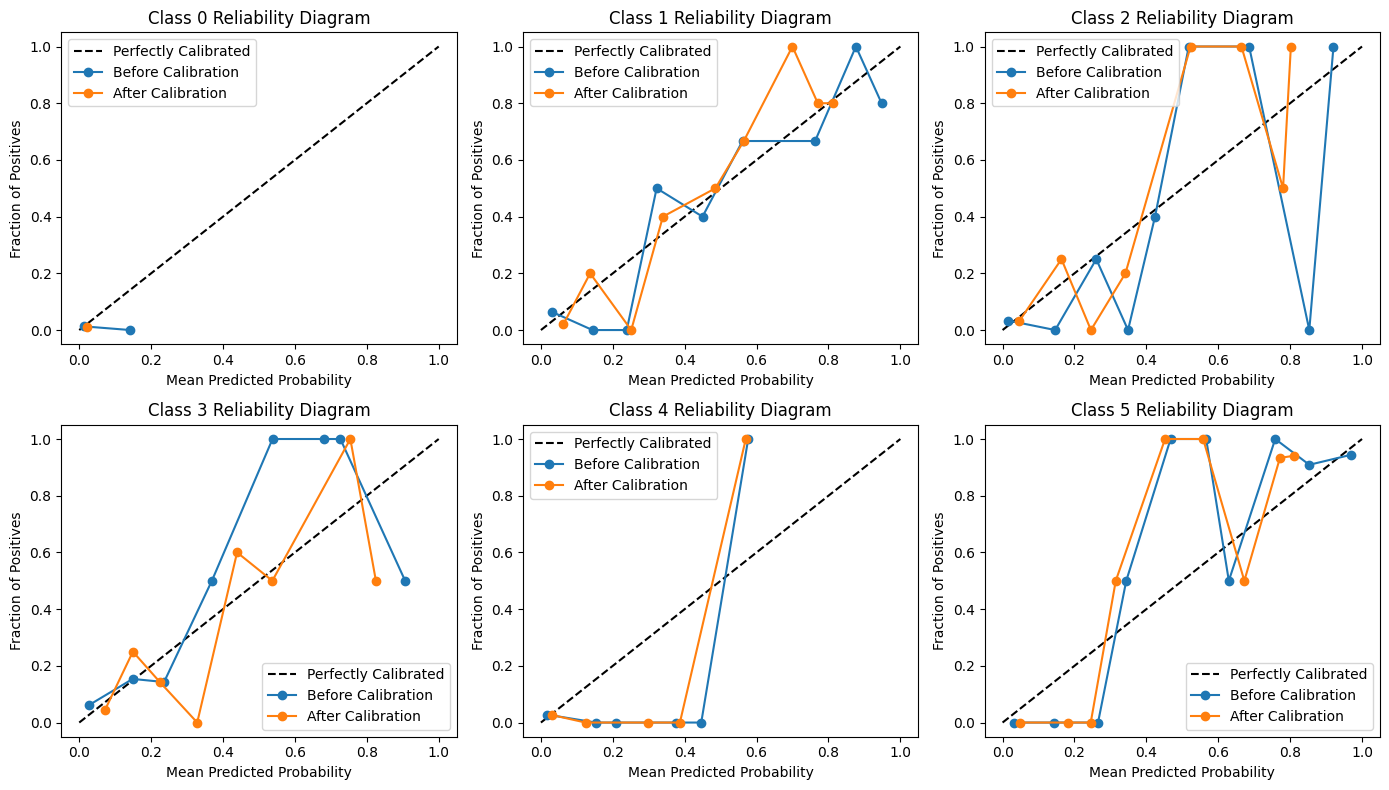

In [100]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

def plot_multiclass_reliability_diagram(y_test, prob_pred, prob_calibrated, n_classes, bins=10):
    plt.figure(figsize=(14, 8))
    
    for i in range(n_classes):
        # One-vs-Rest Calibration for each class
        prob_true, prob_pred_avg = calibration_curve((y_test == i).astype(int), prob_pred[:, i], n_bins=bins)
        prob_true_cal, prob_pred_avg_cal = calibration_curve((y_test == i).astype(int), prob_calibrated[:, i], n_bins=bins)
        
        plt.subplot(2, int(np.ceil(n_classes / 2)), i + 1)
        plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
        plt.plot(prob_pred_avg, prob_true, marker='o', label="Before Calibration")
        plt.plot(prob_pred_avg_cal, prob_true_cal, marker='o', label="After Calibration")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Class {i} Reliability Diagram")
        plt.legend()

    plt.tight_layout()
    plt.show()

# Before calibration
prob_pred = xgb_best.predict_proba(X_test_pca)

# Apply Temperature Scaling using CalibratedClassifierCV
calibrator = CalibratedClassifierCV(xgb_best, method='sigmoid', cv='prefit')
calibrator.fit(X_test_pca, y_test)
prob_calibrated = calibrator.predict_proba(X_test_pca)

# Visualize Reliability Diagrams for all classes
plot_multiclass_reliability_diagram(y_test, prob_pred, prob_calibrated, n_classes=len(np.unique(y_test)))


### Explanation of Reliability Diagram Results

#### Class 0
- **Before Calibration**: The predicted probabilities are heavily misaligned, indicating poor calibration. The model's predictions for Class 0 are overconfident despite low accuracy.
- **After Calibration**: Minimal improvement. Predictions remain far from the perfectly calibrated line, suggesting this class remains challenging for the model.

#### Class 1
- **Before Calibration**: The probabilities are relatively close to the perfect calibration line, though the model tends to overpredict probabilities in certain ranges.
- **After Calibration**: Predictions align much better with the perfect calibration line, especially in the middle probability range, indicating improved confidence estimation.

#### Class 2
- **Before Calibration**: Predictions are erratic, with significant deviations from the perfect line. The model struggles with consistency.
- **After Calibration**: Smoother alignment is achieved, with fewer extreme deviations, improving the reliability of predictions.

#### Class 3
- **Before Calibration**: The predicted probabilities deviate significantly, with overconfidence in the mid-range probability values.
- **After Calibration**: The predictions are better calibrated, reducing the gap between predicted and actual outcomes.

#### Class 4
- **Before Calibration**: This class shows substantial underconfidence, with predicted probabilities underestimating the actual likelihood of positive outcomes.
- **After Calibration**: Predictions improve slightly but still exhibit some misalignment, indicating moderate calibration success.

#### Class 5
- **Before Calibration**: Predictions for this class are reasonably well-calibrated but tend to overpredict in higher probability ranges.
- **After Calibration**: Calibration improves further, with predictions aligning very closely to the perfectly calibrated line, making this class highly reliable post-calibration.

### Summary
- **Overall**: Calibration significantly improved the predicted probabilities for most classes, particularly for Classes 1, 2, and 5.
- **Class 0** remains the most challenging for the model, with little improvement after calibration.
- The reliability diagrams demonstrate the effectiveness of calibration in improving probabilistic predictions, reducing overconfidence or underconfidence across various probability ranges.


In [101]:
from sklearn.metrics import classification_report

# Before calibration
prob_pred = xgb_best.predict_proba(X_test_pca)
y_pred_before = xgb_best.predict(X_test_pca)

# Generate the classification report before calibration
print("Classification Report Before Calibration:")
print(classification_report(y_test, y_pred_before))

# After calibration
calibrator = CalibratedClassifierCV(xgb_best, method='sigmoid', cv='prefit')
calibrator.fit(X_test_pca, y_test)
y_pred_after = calibrator.predict(X_test_pca)

# Generate the classification report after calibration
print("\nClassification Report After Calibration:")
print(classification_report(y_test, y_pred_after))


Classification Report Before Calibration:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.74      0.82      0.78        17
           2       0.75      0.67      0.71         9
           3       0.70      0.50      0.58        14
           4       0.33      0.33      0.33         3
           5       0.90      1.00      0.95        36

    accuracy                           0.80        80
   macro avg       0.57      0.55      0.56        80
weighted avg       0.78      0.80      0.79        80


Classification Report After Calibration:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.71      0.73        17
           2       0.75      0.67      0.71         9
           3       0.53      0.57      0.55        14
           4       0.50      0.33      0.40         3
           5       0.92      1.00      0.96     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

### Comparison of Classification Reports Before and After Calibration

#### **Before Calibration**
- **Accuracy**: 80%
- **Weighted F1 Score**: 0.79
- **Observations**:
  - Class 1, 2, and 5 have strong precision, recall, and F1 scores, indicating good performance.
  - Class 0 has zero precision, recall, and F1 score, showing that the model fails to correctly classify any instances of this class.
  - Class 3 shows moderate performance with lower F1 scores, and Class 4 also struggles, with an F1 score of 0.33.

#### **After Calibration**
- **Accuracy**: Slightly decreases to 79%.
- **Weighted F1 Score**: Decreases marginally to 0.78.
- **Observations**:
  - Precision for Class 1, 2, and 5 remains strong, though there is a slight reduction in precision for Class 1 and Class 3.
  - Class 0 performance does not improve and remains poorly predicted.
  - Class 4 sees an improvement in precision (from 0.33 to 0.50), indicating better predictions after calibration despite a slight recall drop.
  - Class 5 maintains high performance, with only slight changes in metrics.


In [102]:
import joblib

# Save the calibrated model
joblib.dump(calibrator, 'calibrated_xgboost_model.pkl')

# Save the scaler and PCA separately for preprocessing
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')



['pca.pkl']